In [ ]:
!pip install pmdarima

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import statsmodels.api as sm
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')


In [ ]:
product_df = pd.read_csv('Case Study - Product.csv',delimiter=';')
product_df.head()

,ProductID,Product Name,Price
0,P1,Choco Bar,8800
1,P2,Ginger Candy,3200
2,P3,Crackers,7500
3,P4,Potato Chip,12000
4,P5,Thai Tea,4200


In [ ]:
transaction_df = pd.read_csv('Case Study - Transaction.csv',delimiter=';')
transaction_df.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,01/01/2022,P3,7500,4,30000,12
1,TR16356,165,01/01/2022,P9,10000,7,70000,1
2,TR1984,183,01/01/2022,P1,8800,4,35200,4
3,TR35256,160,01/01/2022,P1,8800,7,61600,4
4,TR41231,386,01/01/2022,P9,10000,1,10000,4


In [ ]:
merged_df = pd.merge(transaction_df,product_df,on=["ProductID"])
merged_df.head()

,TransactionID,CustomerID,Date,ProductID,Price_x,Qty,TotalAmount,StoreID,Product Name,Price_y
0,TR11369,328,01/01/2022,P3,7500,4,30000,12,Crackers,7500
1,TR14355,203,02/01/2022,P3,7500,4,30000,10,Crackers,7500
2,TR16534,421,02/01/2022,P3,7500,2,15000,14,Crackers,7500
3,TR10346,322,03/01/2022,P3,7500,4,30000,4,Crackers,7500
4,TR36491,117,03/01/2022,P3,7500,4,30000,12,Crackers,7500


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5020 entries, 0 to 5019
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionID  5020 non-null   object
 1   CustomerID     5020 non-null   int64 
 2   Date           5020 non-null   object
 3   ProductID      5020 non-null   object
 4   Price_x        5020 non-null   int64 
 5   Qty            5020 non-null   int64 
 6   TotalAmount    5020 non-null   int64 
 7   StoreID        5020 non-null   int64 
 8   Product Name   5020 non-null   object
 9   Price_y        5020 non-null   int64 
dtypes: int64(6), object(4)
memory usage: 431.4+ KB


In [ ]:
merged_df["Date"] = pd.to_datetime(merged_df["Date"],infer_datetime_format=True,dayfirst=True)

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5020 entries, 0 to 5019
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   TransactionID  5020 non-null   object        
 1   CustomerID     5020 non-null   int64         
 2   Date           5020 non-null   datetime64[ns]
 3   ProductID      5020 non-null   object        
 4   Price_x        5020 non-null   int64         
 5   Qty            5020 non-null   int64         
 6   TotalAmount    5020 non-null   int64         
 7   StoreID        5020 non-null   int64         
 8   Product Name   5020 non-null   object        
 9   Price_y        5020 non-null   int64         
dtypes: datetime64[ns](1), int64(6), object(3)
memory usage: 431.4+ KB


In [ ]:
columns_to_drop=['TransactionID','CustomerID','ProductID','Price_x','Qty','StoreID','Product Name','Price_y']
merged_df.drop(columns_to_drop,axis=1,inplace=True)

In [ ]:
merged_df.head()

,Date,TotalAmount
0,2022-01-01,30000
1,2022-01-02,30000
2,2022-01-02,15000
3,2022-01-03,30000
4,2022-01-03,30000


In [ ]:
merged_df = merged_df.groupby('Date').sum()
merged_df

,TotalAmount
Date,
2022-01-01,431200
2022-01-02,613600
2022-01-03,561300
2022-01-04,396500
2022-01-05,273400
...,...
2022-12-27,647300
2022-12-28,599000
2022-12-29,437900


In [ ]:
# convert total amount date array
timesteps = merged_df.index
total_amount = merged_df['TotalAmount'].to_numpy()

In [ ]:
timesteps

DatetimeIndex(['2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04',
               '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08',
               '2022-01-09', '2022-01-10',
               ...
               '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25',
               '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2022-12-31'],
              dtype='datetime64[ns]', name='Date', length=365, freq=None)

**Splitting data for training and testing data**

In [ ]:
split_size = int(0.8 * len(timesteps))
X_train,y_train = timesteps[:split_size],total_amount[:split_size]
X_test,y_test = timesteps[split_size:],total_amount[split_size:]

In [ ]:
len(X_train),len(y_train)

(292, 292)

In [ ]:
len(X_test),len(y_test)

(73, 73)

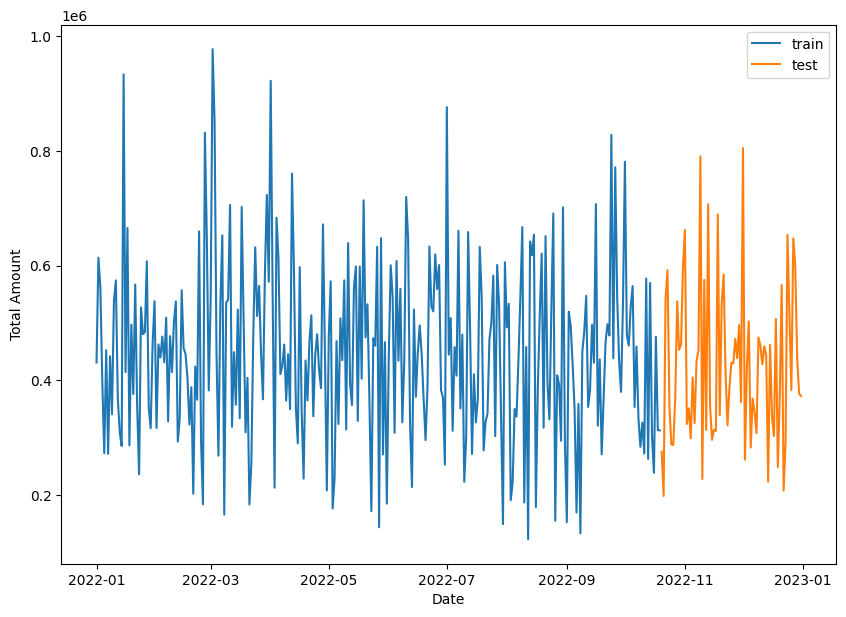

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(X_train,y_train,label='train')
plt.plot(X_test,y_test,label='test')
plt.xlabel('Date')
plt.ylabel('Total Amount')
plt.legend()

## Model Training and Tuning

**Naive Forecast as baseline model**



In [ ]:
naive_forecast = y_test[:-1]

In [ ]:
naive_forecast[-10:]

array([566100, 208400, 292700, 653400, 512600, 383000, 647300, 599000,
       437900, 377000])

In [ ]:
def evaluation_metrics(y_true,y_pred):
  y_true = tf.cast(y_true,dtype=tf.float32)
  y_pred = tf.cast(y_pred,dtype=tf.float32)

  mae = tf.metrics.mean_absolute_error(y_true,y_pred)
  mape = tf.metrics.mean_absolute_percentage_error(y_true,y_pred)
  #return mae
  return {"mae":mae.numpy(),
          "mape":mape.numpy()}

In [ ]:
naive_results=evaluation_metrics(y_test[1:],naive_forecast)
naive_results

{'mae': 150613.89, 'mape': 39.07526}

**ARIMA**

In [ ]:

def ad_test(dataset):

    dftest = adfuller(dataset, autolag = 'AIC')

    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression:",dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
         print("\t",key, ": ", val)


ad_test(merged_df['TotalAmount'])

1. ADF :  -9.037820025169834
2. P-Value :  5.2310384860069985e-15
3. Num Of Lags :  3
4. Num Of Observations Used For ADF Regression: 361
5. Critical Values :
	 1% :  -3.4485948978753314
	 5% :  -2.86957971128312
	 10% :  -2.571053050314224


In [ ]:
stepwise_fit = auto_arima(merged_df['TotalAmount'], trace=True,
suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=9754.493, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=9748.184, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=9749.945, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=9749.950, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=10570.639, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=9752.002, Time=0.13 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.992 seconds


In [ ]:

X = total_amount
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

In [ ]:

for t in range(len(test)):
    model = ARIMA(history, order=(0,0,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=448529.452055, expected=276200.000000
predicted=447941.296928, expected=199000.000000
predicted=447094.557823, expected=542800.000000
predicted=447418.983051, expected=591800.000000
predicted=447906.756757, expected=354600.000000
predicted=447592.592593, expected=288500.000000
predicted=447058.724832, expected=287600.000000
predicted=446525.418060, expected=369700.000000
predicted=446269.333333, expected=537600.000000
predicted=446572.757475, expected=453400.000000
predicted=446595.364238, expected=462000.000000
predicted=446646.204620, expected=598900.000000
predicted=447147.039474, expected=662000.000000
predicted=447851.475410, expected=324200.000000
predicted=447447.385621, expected=351400.000000
predicted=447134.527687, expected=299400.000000
predicted=446654.870130, expected=405100.000000
predicted=446520.388350, expected=325800.000000
predicted=446130.967742, expected=433800.000000
predicted=446091.318328, expected=452500.000000
predicted=446111.858974, expected=790000

In [ ]:
arima_results = evaluation_metrics(test,predictions)
arima_results

{'mae': 111208.23, 'mape': 29.99242}

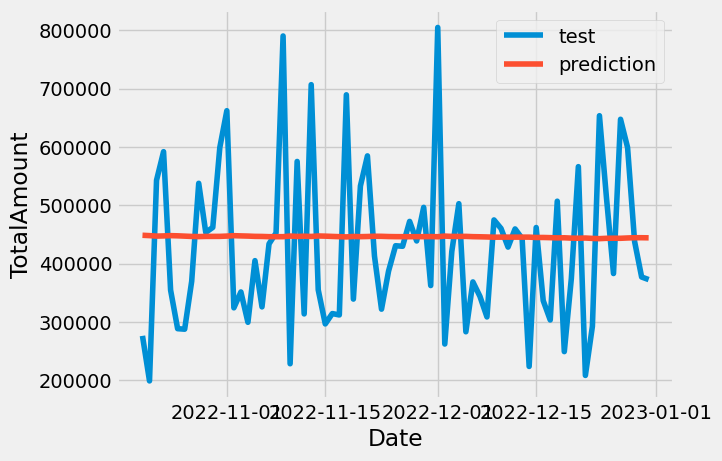

In [702]:
plt.plot(merged_df.index[size:],test,label='test')
plt.plot(merged_df.index[size:],predictions,label='prediction')
plt.xlabel('Date')
plt.ylabel('TotalAmount')
plt.legend()

**SARIMAX**

In [ ]:
p=d=q = range(0,2)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0],x[1],x[2],12) for x in pdq]

In [ ]:
param_dict = {}
pdq_dict = {}
for param in pdq:
  for param_seasonal in seasonal_pdq:
    try:
      mod=sm.tsa.statespace.SARIMAX(total_amount,
                                    order=param,
                                     seasonal_order = param_seasonal,
                                    enforce_stationary=False,
                                      enforce_invertibility=False)
      results=mod.fit()
      param_dict[param_seasonal] = results.aic
      pdq_dict[param] = results.aic
      print(f"ARIMA{param}x{param_seasonal}-AIC:{results.aic}")

    except:
      continue


ARIMA(0, 0, 0)x(0, 0, 0, 12)-AIC:10570.63890062458
ARIMA(0, 0, 0)x(0, 0, 1, 12)-AIC:10482.739336954412
ARIMA(0, 0, 0)x(0, 1, 0, 12)-AIC:9657.478967550729
ARIMA(0, 0, 0)x(0, 1, 1, 12)-AIC:9508.507615384278
ARIMA(0, 0, 0)x(1, 0, 0, 12)-AIC:9988.194770668579
ARIMA(0, 0, 0)x(1, 0, 1, 12)-AIC:9816.856570236672
ARIMA(0, 0, 0)x(1, 1, 0, 12)-AIC:9593.073839247892
ARIMA(0, 0, 0)x(1, 1, 1, 12)-AIC:9507.97218933821
ARIMA(0, 0, 1)x(0, 0, 0, 12)-AIC:10396.376600857382
ARIMA(0, 0, 1)x(0, 0, 1, 12)-AIC:10345.280903468512
ARIMA(0, 0, 1)x(0, 1, 0, 12)-AIC:9659.007701793651
ARIMA(0, 0, 1)x(0, 1, 1, 12)-AIC:9537.009987033007
ARIMA(0, 0, 1)x(1, 0, 0, 12)-AIC:10289.342499376884
ARIMA(0, 0, 1)x(1, 0, 1, 12)-AIC:10270.631882142527
ARIMA(0, 0, 1)x(1, 1, 0, 12)-AIC:9599.767278725787
ARIMA(0, 0, 1)x(1, 1, 1, 12)-AIC:9537.952270556183
ARIMA(0, 1, 0)x(0, 0, 0, 12)-AIC:9981.906231700468
ARIMA(0, 1, 0)x(0, 0, 1, 12)-AIC:9983.187556293684
ARIMA(0, 1, 0)x(0, 1, 0, 12)-AIC:9884.265804339093
ARIMA(0, 1, 0)x(0, 1, 1, 12

In [703]:
#best order (0,0,0)
# best seasonal order (0,1,1,12)
mod = sm.tsa.statespace.SARIMAX(merged_df,
                                order=(0,0,0),
                                seasonal_order=(0,1,1,12),
                                enforce_stationary=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.9318      0.055    -16.857      0.000      -1.040      -0.823
sigma2      3.323e+10   4.84e-13   6.87e+22      0.000    3.32e+10    3.32e+10


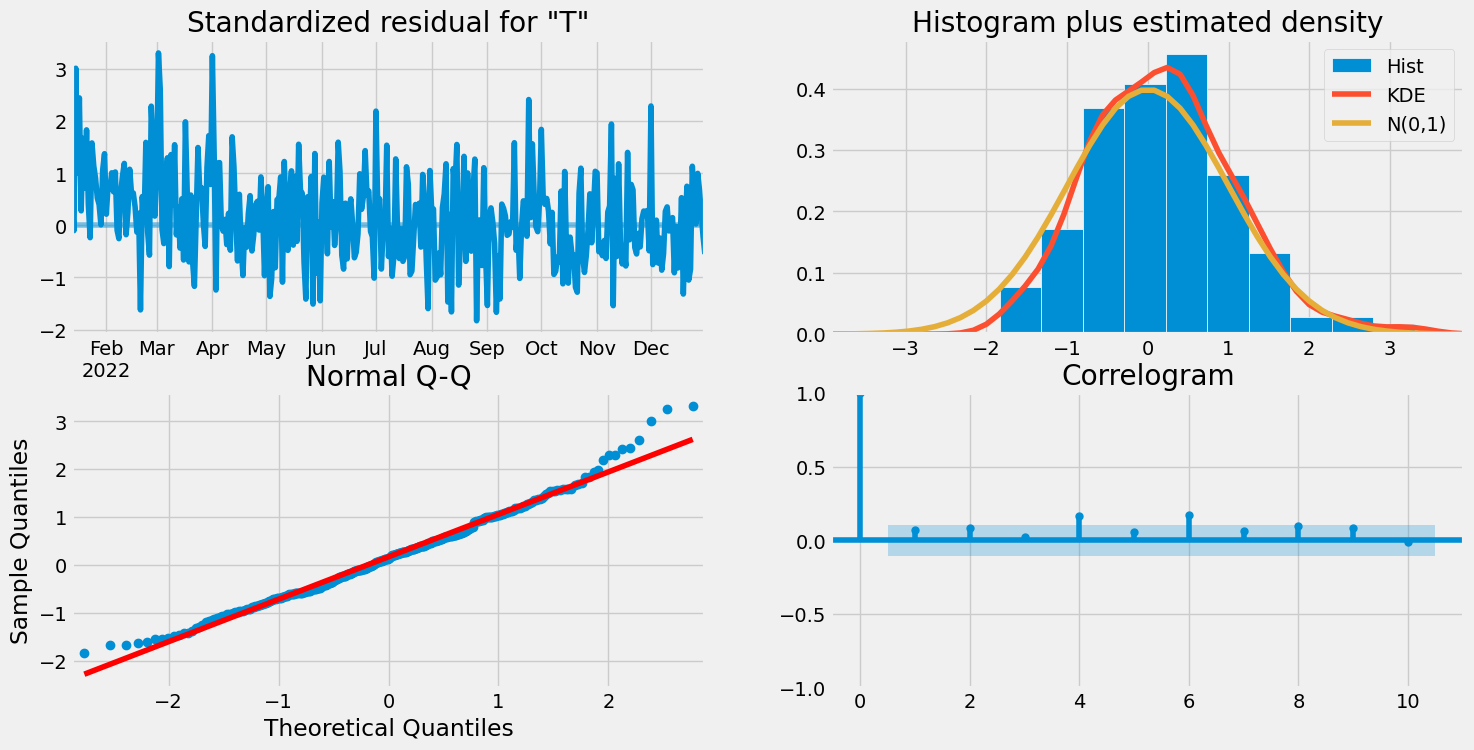

In [704]:
results.plot_diagnostics(figsize=(16,8))
plt.show()

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2022-01-01'),
                              dynamic=False)

In [ ]:
sarimax_pred = pred.predicted_mean

In [ ]:
sarimax_results = evaluation_metrics(merged_df['TotalAmount'],sarimax_pred)
sarimax_results

{'mae': 143501.02, 'mape': 36.452736}

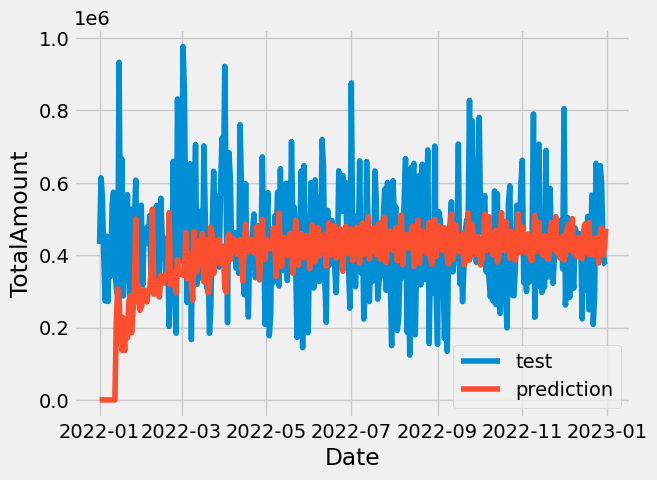

In [705]:
plt.plot(merged_df.index,merged_df.values,label='test')
plt.plot(merged_df.index,sarimax_pred,label='prediction')
plt.xlabel('Date')
plt.ylabel('TotalAmount')
plt.legend()

**Custom LSTM**

In [586]:
import tensorflow as tf

In [659]:
WINDOW_SIZE = 11
HORIZON = 1

In [660]:
def get_labelled_window(x,horizon):
  return x[:,:-horizon], x[:,-horizon:]

In [661]:
def make_windows(x,window_size = WINDOW_SIZE,horizon=HORIZON):
  window_step = np.expand_dims(np.arange(window_size+horizon),axis=0)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)),axis=0).T
  window_array = x[window_indexes]
  windows,label = get_labelled_window(window_array,horizon=horizon)
  return windows,label

In [662]:
full_windows,full_labels = make_windows(total_amount,window_size=WINDOW_SIZE,horizon=HORIZON)
len(full_windows),len(full_labels)

(354, 354)

In [663]:
def train_test_split_timeseries(X,y,test_size=0.2):
  split_size = int(len(X) * (1-test_size))
  X_train,y_train = X[:split_size],y[:split_size]
  X_test,y_test = X[split_size:],y[split_size:]

  return X_train,y_train,X_test,y_test


In [670]:
train_windows,train_labels,test_windows,test_labels = train_test_split_timeseries(full_windows,
                                                                                  full_labels,
                                                                                  test_size=0.1)

In [665]:
#creating training data
train_windows = tf.data.Dataset.from_tensor_slices(train_windows)
train_labels = tf.data.Dataset.from_tensor_slices(train_labels)

#create testing data
test_windows = tf.data.Dataset.from_tensor_slices(test_windows)
test_labels = tf.data.Dataset.from_tensor_slices(test_labels)

#zip feature and labels
train_dataset = tf.data.Dataset.zip((train_windows,train_labels))
test_dataset = tf.data.Dataset.zip((test_windows,test_labels))

In [666]:
#Data pipelining for better performance
BATCH_SIZE = 64
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [667]:
EPOCHS = 200


In [668]:
tf.random.set_seed(42)
inputs = tf.keras.layers.Input(shape = WINDOW_SIZE)
x = tf.keras.layers.Lambda(lambda x :tf.expand_dims(x,axis=1))(inputs)
x = tf.keras.layers.LSTM(512,activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32,activation="relu")(x)
outputs = tf.keras.layers.Dense(HORIZON,activation="linear")(x)

stacked_lstm = tf.keras.Model(inputs = inputs,outputs=outputs)
stacked_lstm.compile(loss="mae",
                     optimizer = tf.keras.optimizers.Adam())

stacked_lstm.fit(train_dataset,
                 epochs = EPOCHS,
                 #batch_size = BATCH_SIZE,
                 validation_data=test_dataset,
                 callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                               patience = 100,
                                                               restore_best_weights=True)]
                                                               )


Epoch 1/200
5/5 [==============================] - 2s 65ms/step - loss: 377404.1875 - val_loss: 278939.6875
Epoch 2/200
5/5 [==============================] - 0s 10ms/step - loss: 231627.7031 - val_loss: 122832.8906
Epoch 3/200
5/5 [==============================] - 0s 8ms/step - loss: 142225.8438 - val_loss: 137378.1875
Epoch 4/200
5/5 [==============================] - 0s 14ms/step - loss: 160347.9688 - val_loss: 113976.1406
Epoch 5/200
5/5 [==============================] - 0s 10ms/step - loss: 137023.5469 - val_loss: 105190.5781
Epoch 6/200
5/5 [==============================] - 0s 9ms/step - loss: 137552.8906 - val_loss: 115149.7109
Epoch 7/200
5/5 [==============================] - 0s 11ms/step - loss: 135488.5469 - val_loss: 105732.9453
Epoch 8/200
5/5 [==============================] - 0s 11ms/step - loss: 130301.5938 - val_loss: 99336.1172
Epoch 9/200
5/5 [==============================] - 0s 10ms/step - loss: 129495.8984 - val_loss: 101731.3906
Epoch 10/200
5/5 [=============

In [526]:
stacked_lstm.evaluate(test_dataset)

1/1 [==============================] - 0s 13ms/step - loss: 97567.4844


97567.484375

In [527]:
def make_pred(model,input_data):
  pred = model.predict(input_data)
  return tf.squeeze(pred)


In [528]:
stacked_lstm_pred = make_pred(stacked_lstm,test_dataset)
stacked_lstm_pred[:10]

1/1 [==============================] - 0s 154ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([349338.66, 429164.1 , 448346.72, 430199.97, 421200.84, 419850.97,
       416385.2 , 435063.06, 452693.56, 449268.9 ], dtype=float32)>

In [529]:
stacked_lstm_results = evaluation_metrics(tf.squeeze(test_labels),stacked_lstm_pred)
stacked_lstm_results

{'mae': 97567.484, 'mape': 23.880028}

In [530]:
stacked_lstm.save_weights('./checkpoints/my_checkpoint')

In [531]:
import joblib
joblib.dump(stacked_lstm,'best_model.pkl')

['best_model.pkl']

In [532]:
load_model = joblib.load('/content/best_model.pkl')

In [533]:
load_model.evaluate(test_dataset)

1/1 [==============================] - 0s 182ms/step - loss: 97567.4844


97567.484375

##Comparing best model for timeseries


In [686]:
model_name = ["Naive model","Arima","Sarimax","Stacked LSTM"]
mae = [naive_results["mae"],arima_results["mae"],sarimax_results["mae"],stacked_lstm_results["mae"]]
mape = [naive_results["mape"],arima_results["mape"],sarimax_results["mape"],stacked_lstm_results["mape"]]

In [687]:
evaluation_metrics_df = pd.DataFrame({'model':model_name,'mae score':mae,'mape':mape})
evaluation_metrics_df.sort_values(by='mae score',ascending=True,ignore_index=True,inplace=True)
evaluation_metrics_df

,model,mae score,mape
0,Stacked LSTM,97567.484375,23.880028
1,Arima,111208.226562,29.992420
2,Sarimax,143501.015625,36.452736
3,Naive model,150613.890625,39.075260


##Visualize Real time vs Forecasting Total Amount

**Creating forecast interval using best model**

In [677]:
def get_upper_and_lower(preds,results):
  mae = results['mae']

  # Multiply std by 1.96 (95% CI from mean )
  interval = 1.96 * mae

  # get lower and upper prediction
  lower,upper = preds - interval,preds + interval

  return lower,upper

In [679]:
lower,upper = get_upper_and_lower(preds=stacked_lstm_pred,results=stacked_lstm_results)

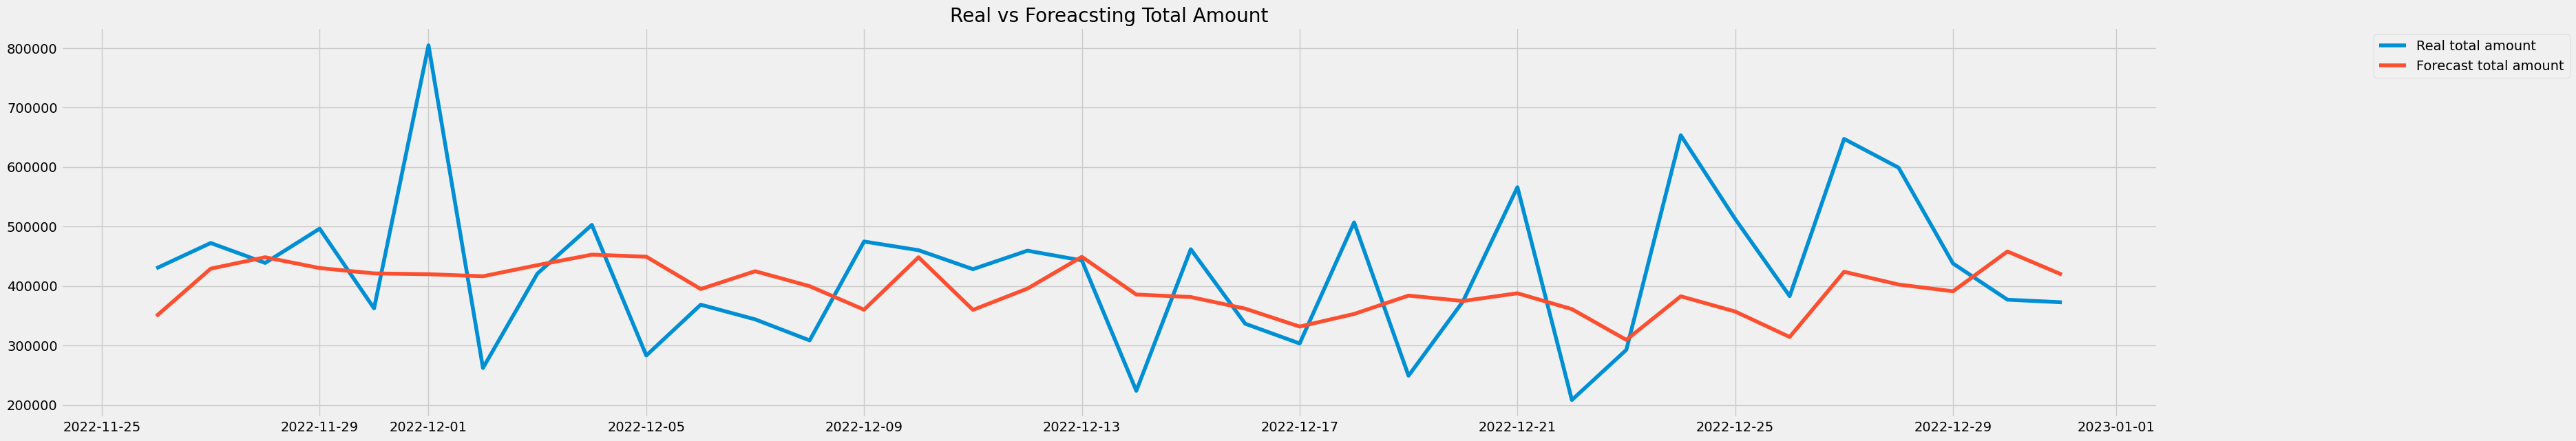

In [701]:

offset = len(X_test)-stacked_lstm_pred.shape[0]
plt.figure(figsize=(35,7))
plt.plot(X_test.index[offset:],tf.squeeze(test_labels),label="Real total amount")
plt.plot(X_test.index[offset:],stacked_lstm_pred,label="Forecast total amount")
plt.title("Real vs Foreacsting Total Amount")
plt.legend(bbox_to_anchor=(1.2,1))
plt.show()

##Next day Prediction

In [688]:
last_total_amount=merged_df[-11:]['TotalAmount'].to_numpy()


In [690]:
last_total_amount_copy = last_total_amount.copy()
forecast = list()
for i in range(3):
  pred = make_pred(stacked_lstm,np.expand_dims(last_total_amount_copy[i:],axis=0))
  forecast.append(pred)
  last_total_amount_copy = np.append(last_total_amount_copy,pred)






1/1 [==============================] - 0s 30ms/step


In [691]:
pred = make_pred(stacked_lstm,np.expand_dims(last_total_amount,axis=0))

1/1 [==============================] - 0s 28ms/step


In [692]:
merged_df[-11:].index

DatetimeIndex(['2022-12-21', '2022-12-22', '2022-12-23', '2022-12-24',
               '2022-12-25', '2022-12-26', '2022-12-27', '2022-12-28',
               '2022-12-29', '2022-12-30', '2022-12-31'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [693]:
new_date = pd.date_range(start='2023-01-01',end='2023-01-03')

In [694]:
new_date

DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03'], dtype='datetime64[ns]', freq='D')

In [695]:
last_amount_forecast = np.append(last_total_amount,forecast)
days_date = np.append(merged_df.index[-WINDOW_SIZE:],new_date)

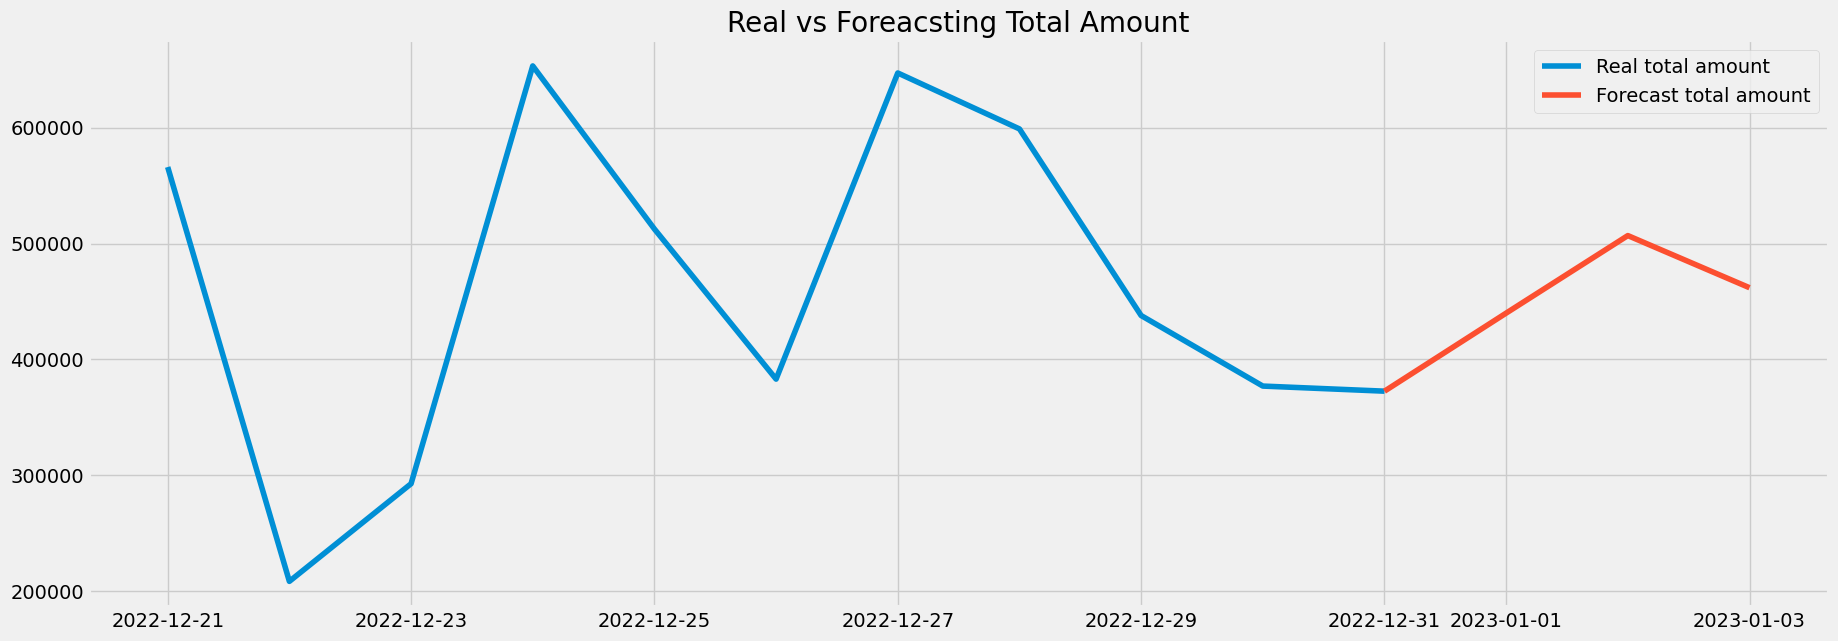

In [698]:
plt.figure(figsize=(20,7))
plt.plot(days_date[:WINDOW_SIZE],last_amount_forecast[:WINDOW_SIZE],label="Real total amount")
plt.plot(days_date[WINDOW_SIZE-1:],last_amount_forecast[WINDOW_SIZE-1:],label="Forecast total amount")
plt.title("Real vs Foreacsting Total Amount")
plt.legend()